In [3]:
from pandas import read_csv, DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from datetime import datetime
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [4]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('datasets/shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)

In [5]:
# lag value of 5 for autoregression, difference order of 1, moving average model of 0
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Fri, 04 Sep 2020   AIC                            406.340
Time:                        09:32:04   BIC                            417.227
Sample:                    02-01-1901   HQIC                           410.098
                         - 12-01-1903                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.001       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

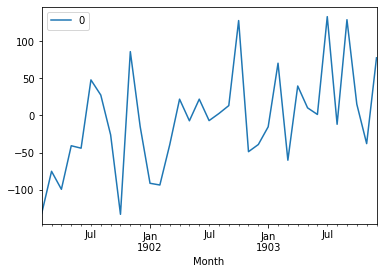

In [6]:
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

Line plot of the residual errors, suggesting there may still be some trend not captured by the model

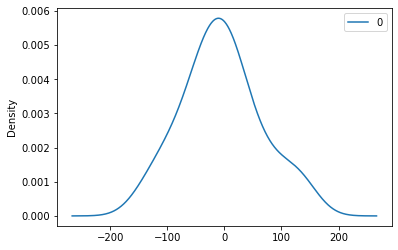

In [7]:
residuals.plot(kind='kde')
pyplot.show()

Density plot of residual error values, suggesting that the errors are Gaussian, but may not be centered on 0.

In [8]:
print(residuals.describe())

                0
count   35.000000
mean    -5.495183
std     68.132883
min   -133.296561
25%    -42.477865
50%     -7.186587
75%     24.748375
max    133.238011


Non zero mean shows that there is a bias in the prediction. 

### Rolling forecaset ARIMA
Crude way to perform rolling forecast is to recreate ARIMA model after each new observation. 

predicted=349.117734, expected=342.300000
predicted=306.513002, expected=339.700000
predicted=387.376436, expected=440.400000
predicted=348.154209, expected=315.900000
predicted=386.308798, expected=439.300000
predicted=356.082063, expected=401.300000
predicted=446.379484, expected=437.400000
predicted=394.737309, expected=575.500000
predicted=434.915469, expected=407.600000
predicted=507.923369, expected=682.000000
predicted=435.482710, expected=475.300000
predicted=652.743868, expected=581.300000
predicted=546.343505, expected=646.900000
Test RMSE: 83.417


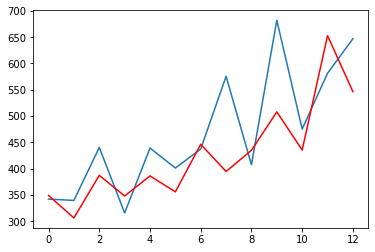

In [9]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### Grid Search

In [10]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out-of-sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [11]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [12]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0 ,3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=228.966
ARIMA(0, 0, 1) RMSE=195.308
ARIMA(0, 0, 2) RMSE=154.886
ARIMA(0, 1, 0) RMSE=134.176
ARIMA(0, 1, 1) RMSE=97.767
ARIMA(0, 1, 2) RMSE=79.412
ARIMA(0, 2, 0) RMSE=259.499
ARIMA(0, 2, 1) RMSE=135.360
ARIMA(1, 0, 0) RMSE=152.030
ARIMA(1, 0, 2) RMSE=85.385
ARIMA(1, 1, 0) RMSE=84.388
ARIMA(1, 1, 1) RMSE=83.688
ARIMA(1, 2, 0) RMSE=136.411
ARIMA(2, 0, 0) RMSE=101.008
ARIMA(2, 1, 0) RMSE=75.432
ARIMA(2, 1, 1) RMSE=88.089
ARIMA(2, 2, 0) RMSE=99.302
ARIMA(4, 0, 0) RMSE=100.185
ARIMA(4, 1, 0) RMSE=81.545
ARIMA(4, 1, 1) RMSE=82.440
ARIMA(4, 2, 0) RMSE=87.157
ARIMA(4, 2, 1) RMSE=68.519
ARIMA(6, 1, 0) RMSE=82.523
ARIMA(6, 1, 1) RMSE=65.908
ARIMA(6, 2, 0) RMSE=79.127
ARIMA(8, 1, 0) RMSE=81.115
ARIMA(10, 1, 0) RMSE=86.852
Best ARIMA(6, 1, 1) RMSE=65.908


predicted=352.377229, expected=342.300000
predicted=307.740339, expected=339.700000
predicted=391.570127, expected=440.400000
predicted=354.431109, expected=315.900000
predicted=389.660280, expected=439.300000
predicted=352.595801, expected=401.300000
predicted=449.205286, expected=437.400000
predicted=399.951074, expected=575.500000
predicted=440.644715, expected=407.600000
predicted=624.390005, expected=682.000000
predicted=449.567538, expected=475.300000
predicted=665.409632, expected=581.300000
predicted=575.992013, expected=646.900000
Test RMSE: 66.772


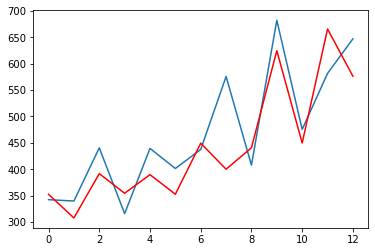

In [13]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(6,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()